In [6]:
import uproot
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

import urllib.request
import os

## Step 1: Define the input file and variables

In [8]:
inputFileName = "Higgs_data.root"
inputFileLink = "http://root.cern.ch/files/" + inputFileName

variables = ["m_jj", "m_jjj", "m_lv", "m_jlv", "m_bb", "m_wbb", "m_wwbb"]

if not os.path.exists(inputFileName):
    print(f"Downloading {inputFileName}...")
    urllib.request.urlretrieve(inputFileLink, inputFileName)
    print(f"Downloaded {inputFileName}.")


with uproot.open(inputFileName) as file:
    signalTree = file['sig_tree']
    signal_data = signalTree.arrays(variables, library="pd")
    backgroundTree = file['bkg_tree']
    background_data = backgroundTree.arrays(variables, library="pd")

Downloaded Higgs_data.root.


In [9]:
signal_data

,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
4,0.869418,1.222083,1.000627,0.545045,0.698653,0.977314,0.828786


In [12]:
background_data.head()

,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
1,0.823761,0.938191,0.971758,0.789176,0.430553,0.961357,0.957818
2,0.944536,1.026261,0.982197,0.542115,1.250979,0.830045,0.761308
3,0.689434,0.867230,1.082488,0.664142,0.354115,0.579945,0.817273
4,0.954494,0.651039,1.124950,0.894001,0.672173,1.182358,1.316304


array([[<Axes: title={'center': 'm_jj'}>,
        <Axes: title={'center': 'm_jjj'}>,
        <Axes: title={'center': 'm_lv'}>],
       [<Axes: title={'center': 'm_jlv'}>,
        <Axes: title={'center': 'm_bb'}>,
        <Axes: title={'center': 'm_wbb'}>],
       [<Axes: title={'center': 'm_wwbb'}>, <Axes: >, <Axes: >]],
      dtype=object)

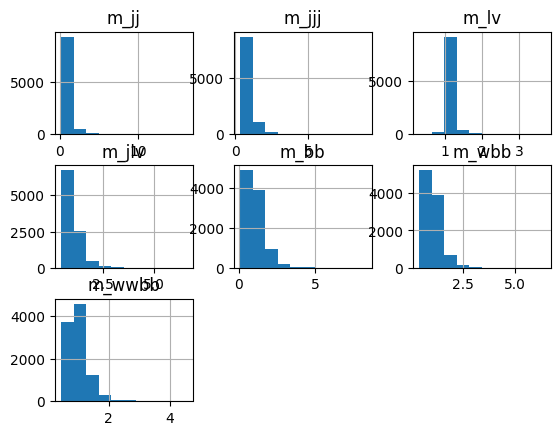

In [21]:
#figsize=(6, 4)
background_data.hist()

array([[<Axes: xlabel='m_jj', ylabel='m_jj'>,
        <Axes: xlabel='m_jjj', ylabel='m_jj'>,
        <Axes: xlabel='m_lv', ylabel='m_jj'>,
        <Axes: xlabel='m_jlv', ylabel='m_jj'>,
        <Axes: xlabel='m_bb', ylabel='m_jj'>,
        <Axes: xlabel='m_wbb', ylabel='m_jj'>,
        <Axes: xlabel='m_wwbb', ylabel='m_jj'>],
       [<Axes: xlabel='m_jj', ylabel='m_jjj'>,
        <Axes: xlabel='m_jjj', ylabel='m_jjj'>,
        <Axes: xlabel='m_lv', ylabel='m_jjj'>,
        <Axes: xlabel='m_jlv', ylabel='m_jjj'>,
        <Axes: xlabel='m_bb', ylabel='m_jjj'>,
        <Axes: xlabel='m_wbb', ylabel='m_jjj'>,
        <Axes: xlabel='m_wwbb', ylabel='m_jjj'>],
       [<Axes: xlabel='m_jj', ylabel='m_lv'>,
        <Axes: xlabel='m_jjj', ylabel='m_lv'>,
        <Axes: xlabel='m_lv', ylabel='m_lv'>,
        <Axes: xlabel='m_jlv', ylabel='m_lv'>,
        <Axes: xlabel='m_bb', ylabel='m_lv'>,
        <Axes: xlabel='m_wbb', ylabel='m_lv'>,
        <Axes: xlabel='m_wwbb', ylabel='m_lv'>],
       [<

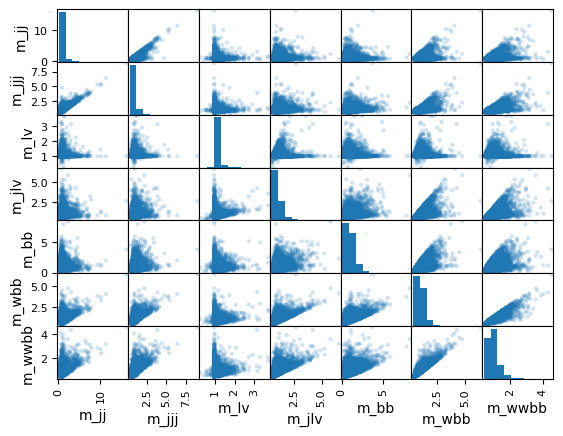

In [22]:
pd.plotting.scatter_matrix(background_data, alpha=0.2)

### Label the data

In [ ]:
signal_data["label"] = 1
background_data["label"] = 0

### Combine the datasets

In [26]:
combined_data = pd.concat([signal_data, background_data]).reset_index(drop=True)

# Split into features (X) and labels (y)
X = combined_data[variables]
y = combined_data["label"]

### Split the data into training and testing sets

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Train the Fisher Discriminant using Linear Discriminant Analysis (LDA)

In [28]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis()

### Evaluate the model

In [29]:
y_train_pred = lda.predict(X_train)
y_test_pred = lda.predict(X_test)

### Predict probabilities

In [31]:
y_train_prob = lda.predict_proba(X_train)[:, 1]
y_test_prob = lda.predict_proba(X_test)[:, 1]

### Compute ROC curve and ROC area for the test set

In [32]:
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

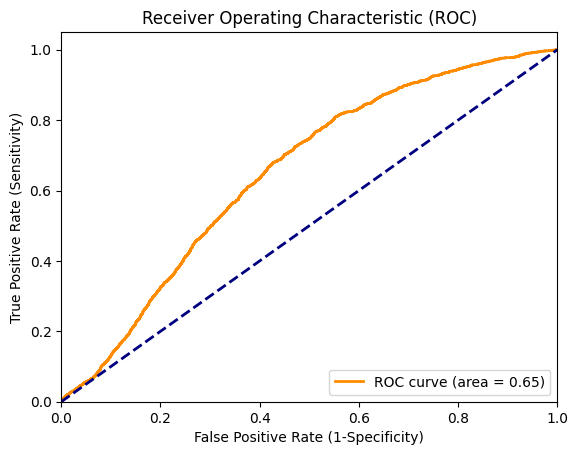

In [37]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

(array([  82.,  208.,  475., 1050., 2275., 4864., 4340.,  624.,   70.,
          12.]),
 array([7.13777961e-04, 9.34242755e-02, 1.86134771e-01, 2.78845280e-01,
        3.71555775e-01, 4.64266270e-01, 5.56976795e-01, 6.49687290e-01,
        7.42397785e-01, 8.35108280e-01, 9.27818775e-01]),
 <BarContainer object of 10 artists>)

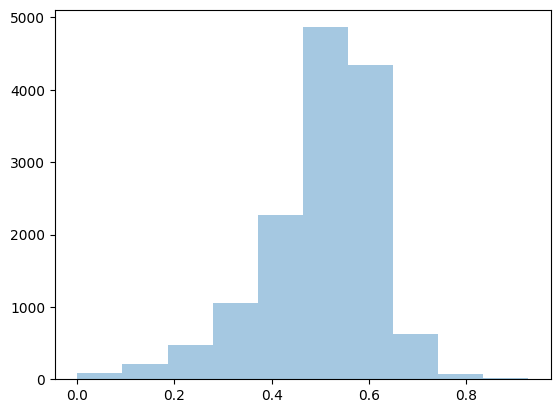

In [35]:
plt.hist(y_train_prob, alpha=0.4)
plt.hist()

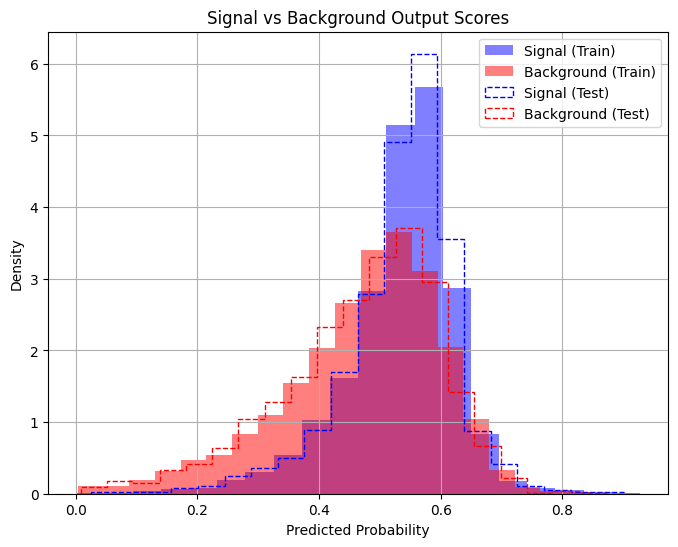

In [36]:
# Separate probabilities by class
train_signal_probs = y_train_prob[y_train == 1]
train_background_probs = y_train_prob[y_train == 0]
test_signal_probs = y_test_prob[y_test == 1]
test_background_probs = y_test_prob[y_test == 0]

# Plotting the distributions
plt.figure(figsize=(8, 6))

# Plot histograms or KDEs for training data
plt.hist(train_signal_probs, bins=20, density=True, alpha=0.5, color='blue', label='Signal (Train)')
plt.hist(train_background_probs, bins=20, density=True, alpha=0.5, color='red', label='Background (Train)')

# Plot histograms or KDEs for test data
plt.hist(test_signal_probs, bins=20, density=True, histtype='step', linestyle='dashed', color='blue', label='Signal (Test)')
plt.hist(test_background_probs, bins=20, density=True, histtype='step', linestyle='dashed', color='red', label='Background (Test)')

plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('Signal vs Background Output Scores')
plt.legend()
plt.grid(True)
plt.show()